PROYECTO UNIDAD II - DEEP LEARNING

Integrantes:
* Pachari Lipa Milton Alexis - 204803
* Sullcarani Diaz Boris Eloy - 200788
* Torreblanca Paz Sebastian Víctor - 204808

## Descripción del Proyecto

- Clasificación de 83 variedades de papas nativas peruanas usando CNN.
- Imágenes con resolución de 128x128 píxeles.
- Comparación entre un modelo personalizado y modelos preentrenados (VGG16, SqueezeNet, MobileNetV2).
- Evaluación de precisión, eficiencia y uso de recursos.
- Uso de técnicas de regularización y data augmentation para mejorar el desempeño.
- Objetivo: facilitar la identificación automática y precisa de variedades agrícolas.

## Descripción del Dataset

- Dataset con imágenes de 83 variedades de papas nativas.
- Imágenes redimensionadas a 128x128 píxeles.
- Alta diversidad morfológica que representa un reto para la clasificación automática.
- Dataset clave para evaluar modelos en un contexto agrícola real.

## IMPORTAR LOS DATOS

Para la obtencion de las imagenes de 83 variedades de papa, consideramos usar los datos alamacenados en el siguiente repositorio de github:
https://github.com/aprendizajeautomatico-entrega2/2DA_ENTREGA_APRENDIZAJE_AUTOMATICO/tree/main/fotos_papas_mismas_dimensiones

In [ ]:
# MÓDULO 1: DESCARGADOR DE IMÁGENES
import os
import requests
import time
from pathlib import Path
import json

def check_rate_limit():
    """
    Verifica el límite de velocidad de la API de GitHub
    """
    try:
        response = requests.get("https://api.github.com/rate_limit")
        if response.status_code == 200:
            data = response.json()
            remaining = data['rate']['remaining']
            reset_time = data['rate']['reset']
            return remaining, reset_time
    except:
        pass
    return None, None

def wait_for_rate_limit_reset(reset_time):
    """
    Espera hasta que se resetee el límite de velocidad
    """
    current_time = time.time()
    wait_seconds = reset_time - current_time + 60  # +60 segundos de margen

    if wait_seconds > 0:
        print(f"⏳ Límite de API alcanzado. Esperando {int(wait_seconds/60)} minutos...")

        # Mostrar progreso cada minuto
        while wait_seconds > 0:
            mins = int(wait_seconds / 60)
            secs = int(wait_seconds % 60)
            print(f"   Tiempo restante: {mins:02d}:{secs:02d}", end='\r')

            sleep_time = min(60, wait_seconds)
            time.sleep(sleep_time)
            wait_seconds -= sleep_time

        print("\n✅ Límite de API reseteado. Continuando...")

def safe_api_request(url, max_retries=3):
    """
    Hace una petición a la API con manejo de límites de velocidad
    """
    for attempt in range(max_retries):
        try:
            response = requests.get(url)

            if response.status_code == 200:
                return response
            elif response.status_code == 403:
                # Verificar si es un error de rate limit
                if 'rate limit exceeded' in response.text.lower():
                    print(f"   ⚠️  Rate limit alcanzado en intento {attempt + 1}")

                    # Verificar cuándo se resetea
                    remaining, reset_time = check_rate_limit()
                    if reset_time:
                        wait_for_rate_limit_reset(reset_time)
                        continue
                    else:
                        # Esperar un tiempo fijo si no podemos obtener el reset time
                        wait_time = 60 * (attempt + 1)  # 1, 2, 3 minutos
                        print(f"   ⏳ Esperando {wait_time} segundos...")
                        time.sleep(wait_time)
                        continue
                else:
                    raise requests.exceptions.RequestException(f"Error 403: {response.text}")
            else:
                response.raise_for_status()

        except requests.exceptions.RequestException as e:
            print(f"   ❌ Error en intento {attempt + 1}: {e}")
            if attempt == max_retries - 1:
                raise
            time.sleep(5 * (attempt + 1))  # Esperar 5, 10, 15 segundos

    return None

def download_images_from_github():
    """
    Descarga solo las imágenes de las carpetas V*_rez desde GitHub
    usando la API de GitHub con manejo de límites de velocidad
    """

    # Configuración del repositorio
    owner = "aprendizajeautomatico-entrega2"
    repo = "2DA_ENTREGA_APRENDIZAJE_AUTOMATICO"
    base_path = "fotos_papas_mismas_dimensiones"

    # Crear carpeta de descarga
    download_dir = "imagenes_originales"
    if os.path.exists(download_dir):
        import shutil
        shutil.rmtree(download_dir)
    os.makedirs(download_dir)

    # Extensiones válidas
    valid_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}

    print("🔍 Obteniendo lista de carpetas...")
    print("💡 Verificando límite de API...")

    # Verificar límite de API al inicio
    remaining, reset_time = check_rate_limit()
    if remaining is not None:
        print(f"   📊 Peticiones disponibles: {remaining}")
        if remaining < 50:
            print(f"   ⚠️  Pocas peticiones restantes, esperando...")
            wait_for_rate_limit_reset(reset_time)

    # URL de la API de GitHub para obtener contenido de la carpeta
    api_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{base_path}"

    try:
        response = safe_api_request(api_url)
        if not response:
            return False
        folders_data = response.json()
    except requests.exceptions.RequestException as e:
        print(f"❌ Error al acceder a la API de GitHub: {e}")
        return False

    # Filtrar solo carpetas V*_rez
    target_folders = []
    for item in folders_data:
        if (item['type'] == 'dir' and
            item['name'].startswith('V') and
            item['name'].endswith('_rez')):
            target_folders.append(item['name'])

    target_folders.sort(key=lambda x: int(x[1:].split('_')[0]))  # Ordenar por número

    print(f"📁 Encontradas {len(target_folders)} carpetas:")
    for folder in target_folders:
        print(f"   • {folder}")

    total_downloaded = 0

    # Procesar cada carpeta
    for folder_name in target_folders:
        print(f"\n📂 Procesando {folder_name}...")

        # Crear carpeta local
        local_folder = os.path.join(download_dir, folder_name)
        os.makedirs(local_folder, exist_ok=True)

        # Obtener contenido de la carpeta
        folder_api_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{base_path}/{folder_name}"

        try:
            folder_response = safe_api_request(folder_api_url)
            if not folder_response:
                print(f"   ❌ No se pudo acceder a {folder_name}")
                continue
            files_data = folder_response.json()
        except requests.exceptions.RequestException as e:
            print(f"   ❌ Error al acceder a {folder_name}: {e}")
            continue

        # Filtrar solo archivos de imagen
        image_files = []
        for file_item in files_data:
            if (file_item['type'] == 'file' and
                Path(file_item['name']).suffix in valid_extensions):
                image_files.append(file_item)

        print(f"   🖼️  Encontradas {len(image_files)} imágenes")

        # Descargar cada imagen
        folder_downloaded = 0
        for file_item in image_files:
            file_name = file_item['name']
            download_url = file_item['download_url']
            local_file_path = os.path.join(local_folder, file_name)

            try:
                # Descargar archivo
                file_response = requests.get(download_url)
                file_response.raise_for_status()

                # Guardar archivo
                with open(local_file_path, 'wb') as f:
                    f.write(file_response.content)

                folder_downloaded += 1
                total_downloaded += 1

                # Pausa más larga para evitar rate limiting
                time.sleep(0.5)  # Aumentado de 0.1 a 0.5 segundos

                # Verificar límite cada 10 descargas
                if total_downloaded % 10 == 0:
                    remaining, _ = check_rate_limit()
                    if remaining is not None and remaining < 20:
                        print(f"      ⚠️  Pocas peticiones restantes ({remaining}), haciendo pausa...")
                        time.sleep(2)

            except requests.exceptions.RequestException as e:
                print(f"      ❌ Error descargando {file_name}: {e}")
                continue

        print(f"   ✅ Descargadas {folder_downloaded} imágenes de {folder_name}")

    print(f"\n🎉 ¡Descarga completada!")
    print(f"📊 Total de imágenes descargadas: {total_downloaded}")
    print(f"📁 Carpetas creadas en: {download_dir}/")

    # Mostrar resumen
    print(f"\n📋 Resumen por carpeta:")
    for folder in sorted(os.listdir(download_dir)):
        folder_path = os.path.join(download_dir, folder)
        if os.path.isdir(folder_path):
            img_count = len([f for f in os.listdir(folder_path)
                           if Path(f).suffix.lower() in {'.jpg', '.jpeg', '.png'}])
            print(f"   📂 {folder}: {img_count} imágenes")

    return True

def verify_download():
    """
    Verifica que las imágenes se hayan descargado correctamente
    """
    download_dir = "imagenes_originales"

    if not os.path.exists(download_dir):
        print("❌ No se encontró la carpeta de descargas")
        return

    print(f"\n🔍 Verificando descargas...")

    total_folders = 0
    total_images = 0
    sample_images = []

    for folder in sorted(os.listdir(download_dir)):
        folder_path = os.path.join(download_dir, folder)
        if os.path.isdir(folder_path):
            total_folders += 1
            images_in_folder = []

            for filename in os.listdir(folder_path):
                if Path(filename).suffix.lower() in {'.jpg', '.jpeg', '.png'}:
                    images_in_folder.append(filename)
                    total_images += 1

            # Agregar una imagen de muestra
            if images_in_folder and len(sample_images) < 3:
                sample_path = os.path.join(folder_path, images_in_folder[0])
                try:
                    from PIL import Image
                    with Image.open(sample_path) as img:
                        sample_images.append(f"{folder}/{images_in_folder[0]}: {img.size}")
                except:
                    sample_images.append(f"{folder}/{images_in_folder[0]}: Error al leer")

    print(f"✅ Verificación completada:")
    print(f"   📁 Carpetas: {total_folders}")
    print(f"   🖼️  Imágenes: {total_images}")

    if sample_images:
        print(f"\n📏 Dimensiones de muestra:")
        for sample in sample_images:
            print(f"   • {sample}")

# Ejecutar descarga
if __name__ == "__main__":
    print("🚀 MÓDULO 1: DESCARGADOR DE IMÁGENES")
    print("=" * 50)

    success = download_images_from_github()

    if success:
        verify_download()
        print(f"\n✅ Descarga completada. Ejecuta el MÓDULO 2 para redimensionar.")
    else:
        print(f"\n❌ Error en la descarga.")

🚀 MÓDULO 1: DESCARGADOR DE IMÁGENES
🔍 Obteniendo lista de carpetas...
💡 Verificando límite de API...
   📊 Peticiones disponibles: 60
📁 Encontradas 83 carpetas:
   • V1_rez
   • V2_rez
   • V3_rez
   • V4_rez
   • V5_rez
   • V6_rez
   • V7_rez
   • V8_rez
   • V9_rez
   • V10_rez
   • V11_rez
   • V12_rez
   • V13_rez
   • V14_rez
   • V15_rez
   • V16_rez
   • V17_rez
   • V18_rez
   • V19_rez
   • V20_rez
   • V21_rez
   • V22_rez
   • V23_rez
   • V24_rez
   • V25_rez
   • V26_rez
   • V27_rez
   • V28_rez
   • V29_rez
   • V30_rez
   • V31_rez
   • V32_rez
   • V33_rez
   • V34_rez
   • V35_rez
   • V36_rez
   • V37_rez
   • V38_rez
   • V39_rez
   • V40_rez
   • V41_rez
   • V42_rez
   • V43_rez
   • V44_rez
   • V45_rez
   • V46_rez
   • V47_rez
   • V48_rez
   • V49_rez
   • V50_rez
   • V51_rez
   • V52_rez
   • V53_rez
   • V54_rez
   • V55_rez
   • V56_rez
   • V57_rez
   • V58_rez
   • V59_rez
   • V60_rez
   • V61_rez
   • V62_rez
   • V63_rez
   • V64_rez
   • V65_rez
   •

## PREPROCESAMIENTO

### REDIMENSIONAMIENTO DE LOS DATOS

PARA OBTENER LAS CARPETAS DE IMAGENES DE 83 VARIEDADES DE PAPA REDIMENSIONADAS A 128 X 128 PÍXELES EN GOOGLE DRIVE usar el siguiente codigo

In [ ]:
# MÓDULO 2: REDIMENSIONADOR DE IMÁGENES a 128x128 píxeles(VERSIÓN GOOGLE DRIVE)
import os
import shutil
from PIL import Image
from pathlib import Path

# Configuración de Google Drive
GOOGLE_DRIVE_PATH = "/content/drive/MyDrive/dataset_papas"  # Ruta base en Drive
OUTPUT_DIR = "imagenes_papas_128x128"  # Nombre de la carpeta de salida

def mount_google_drive():
    """Monta Google Drive si no está montado ya"""
    if not os.path.exists("/content/drive"):
        from google.colab import drive
        drive.mount('/content/drive')
        print("✅ Google Drive montado correctamente")
    else:
        print("✅ Google Drive ya está montado")

def resize_images_to_any(width,height):
    """
    Redimensiona las imágenes descargadas de 1000x1000 a cualquier dimension
    y las guarda en Google Drive en la ruta especificada
    """

    # Montar Google Drive
    mount_google_drive()

    # Carpetas de origen y destino
    source_dir = "imagenes_originales"
    drive_output_dir = os.path.join(GOOGLE_DRIVE_PATH, OUTPUT_DIR)

    # Verificar que existe la carpeta de origen
    if not os.path.exists(source_dir):
        print("❌ No se encontró la carpeta 'imagenes_originales'")
        print("   Ejecuta primero el MÓDULO 1 para descargar las imágenes")
        return False

    # Crear/limpiar carpeta de destino en Drive
    if os.path.exists(drive_output_dir):
        shutil.rmtree(drive_output_dir)
    os.makedirs(drive_output_dir)

    print(f"🔄 Iniciando redimensionamiento a 64x64...")
    print(f"📁 Las imágenes se guardarán en: {drive_output_dir}")

    # Extensiones válidas
    valid_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}

    total_processed = 0
    folders_processed = 0
    errors = []

    # Procesar cada carpeta
    for folder_name in sorted(os.listdir(source_dir)):
        source_folder_path = os.path.join(source_dir, folder_name)

        if os.path.isdir(source_folder_path):
            print(f"\n📂 Procesando {folder_name}...")

            # Crear nombre de carpeta de destino (quitar "_rez")
            dest_folder_name = folder_name.replace("_rez", "")
            dest_folder_path = os.path.join(drive_output_dir, dest_folder_name)
            os.makedirs(dest_folder_path, exist_ok=True)

            # Contar imágenes en la carpeta
            images_in_folder = [f for f in os.listdir(source_folder_path)
                              if Path(f).suffix in valid_extensions]

            print(f"   🖼️  Encontradas {len(images_in_folder)} imágenes")

            processed_in_folder = 0

            # Procesar cada imagen
            for filename in images_in_folder:
                source_path = os.path.join(source_folder_path, filename)
                dest_path = os.path.join(dest_folder_path, filename)

                try:
                    # Abrir imagen original
                    with Image.open(source_path) as img:
                        # Verificar dimensiones originales
                        original_size = img.size

                        # Redimensionar a 64x64 manteniendo calidad
                        img_resized = img.resize((width,height), Image.Resampling.LANCZOS)

                        # Guardar imagen redimensionada
                        # Mantener formato original pero optimizar calidad
                        if img.format == 'JPEG' or filename.lower().endswith('.jpg'):
                            img_resized.save(dest_path, 'JPEG', quality=95, optimize=True)
                        else:
                            img_resized.save(dest_path, img.format, optimize=True)

                        processed_in_folder += 1
                        total_processed += 1

                        # Mostrar progreso cada 10 imágenes
                        if processed_in_folder % 10 == 0:
                            print(f"      ⏳ {processed_in_folder}/{len(images_in_folder)} procesadas...")

                except Exception as e:
                    error_msg = f"Error en {folder_name}/{filename}: {str(e)}"
                    errors.append(error_msg)
                    print(f"      ❌ {error_msg}")

            print(f"   ✅ {processed_in_folder} imágenes redimensionadas → {dest_folder_name}/")
            folders_processed += 1

    # Mostrar resumen final
    print(f"\n🎉 ¡Redimensionamiento completado!")
    print(f"📊 Estadísticas:")
    print(f"   📁 Carpetas procesadas: {folders_processed}")
    print(f"   🖼️  Imágenes redimensionadas: {total_processed}")
    print(f"   ❌ Errores: {len(errors)}")
    print(f"   📍 Ubicación en Google Drive: {drive_output_dir}")

    if errors:
        print(f"\n⚠️  Errores encontrados:")
        for error in errors[:5]:  # Mostrar solo los primeros 5 errores
            print(f"   • {error}")
        if len(errors) > 5:
            print(f"   ... y {len(errors) - 5} errores más")

    # Mostrar estructura final
    print(f"\n📁 Estructura creada en Google Drive:")
    for folder in sorted(os.listdir(drive_output_dir)):
        folder_path = os.path.join(drive_output_dir, folder)
        if os.path.isdir(folder_path):
            img_count = len([f for f in os.listdir(folder_path)
                           if Path(f).suffix.lower() in {'.jpg', '.jpeg', '.png'}])
            print(f"   📂 {folder}/ ({img_count} imágenes de ",width,"x",height,"px)")

    return True

def verify_resized_images(sample_count,width,height):
    """
    Verifica las dimensiones de las imágenes redimensionadas en Google Drive
    """
    drive_output_dir = os.path.join(GOOGLE_DRIVE_PATH, OUTPUT_DIR)

    if not os.path.exists(drive_output_dir):
        print("❌ No se encontró la carpeta de imágenes redimensionadas en Google Drive")
        return

    print(f"\n🔍 Verificando dimensiones (muestra de {sample_count} imágenes):")

    verified = 0
    all_correct = True

    for folder in sorted(os.listdir(drive_output_dir)):
        folder_path = os.path.join(drive_output_dir, folder)
        if os.path.isdir(folder_path) and verified < sample_count:

            for filename in os.listdir(folder_path):
                if (Path(filename).suffix.lower() in {'.jpg', '.jpeg', '.png'}
                    and verified < sample_count):

                    img_path = os.path.join(folder_path, filename)
                    try:
                        with Image.open(img_path) as img:
                            size = img.size
                            status = "✅" if size == (width,height) else "❌"
                            print(f"   {status} {folder}/{filename}: {size}")

                            if size != (width,height):
                                all_correct = False

                            verified += 1

                    except Exception as e:
                        print(f"   ❌ Error verificando {folder}/{filename}: {e}")
                        all_correct = False

    if all_correct and verified > 0:
        print(f"✅ Todas las imágenes verificadas tienen el tamaño correcto",)
    elif verified == 0:
        print("⚠️  No se pudieron verificar imágenes")
    else:
        print("⚠️  Algunas imágenes no tienen el tamaño correcto")

def get_dataset_info():
    """
    Muestra información del dataset para usar en CNN
    """
    drive_output_dir = os.path.join(GOOGLE_DRIVE_PATH, OUTPUT_DIR)

    if not os.path.exists(drive_output_dir):
        print("❌ No se encontró la carpeta de dataset en Google Drive")
        return

    print("\n📋 INFORMACIÓN DEL DATASET PARA CNN:")
    print(f"=" * 40)

    folders = sorted([f for f in os.listdir(drive_output_dir)
                     if os.path.isdir(os.path.join(drive_output_dir, f))])

    total_images = 0
    for folder in folders:
        folder_path = os.path.join(drive_output_dir, folder)
        img_count = len([f for f in os.listdir(folder_path)
                        if Path(f).suffix.lower() in {'.jpg', '.jpeg', '.png'}])
        total_images += img_count

    print(f"📁 Carpeta del dataset: {drive_output_dir}/")
    print(f"🏷️  Número de clases: {len(folders)}")
    print(f"🖼️  Total de imágenes: {total_images}")
    print(f"📊 Clases: {', '.join(folders)}")

# Ejecutar redimensionamiento
if __name__ == "__main__":
    print("🚀 MÓDULO 2: REDIMENSIONADOR DE IMÁGENES (GOOGLE DRIVE)")
    print("=" * 60)
    print(f"🔹 Las imágenes redimensionadas se guardarán en Google Drive")
    print(f"🔹 Ruta de destino: {GOOGLE_DRIVE_PATH}/{OUTPUT_DIR}\n")

    width,height=128,128
    success = resize_images_to_any(width,height)

    if success:
        verify_resized_images(5,width,height)
        get_dataset_info()
        print(f"\n✅ ¡Imágenes redimensionadas guardadas en Google Drive!")
    else:
        print(f"\n❌ Error en el redimensionamiento.")

🚀 MÓDULO 2: REDIMENSIONADOR DE IMÁGENES (GOOGLE DRIVE)
🔹 Las imágenes redimensionadas se guardarán en Google Drive
🔹 Ruta de destino: /content/drive/MyDrive/dataset_papas/imagenes_papas_128x128

Mounted at /content/drive
✅ Google Drive montado correctamente
🔄 Iniciando redimensionamiento a 64x64...
📁 Las imágenes se guardarán en: /content/drive/MyDrive/dataset_papas/imagenes_papas_128x128

📂 Procesando V10_rez...
   🖼️  Encontradas 76 imágenes
      ⏳ 10/76 procesadas...
      ⏳ 20/76 procesadas...
      ⏳ 30/76 procesadas...
      ⏳ 40/76 procesadas...
      ⏳ 50/76 procesadas...
      ⏳ 60/76 procesadas...
      ⏳ 70/76 procesadas...
   ✅ 76 imágenes redimensionadas → V10/

📂 Procesando V11_rez...
   🖼️  Encontradas 50 imágenes
      ⏳ 10/50 procesadas...
      ⏳ 20/50 procesadas...
      ⏳ 30/50 procesadas...
      ⏳ 40/50 procesadas...
      ⏳ 50/50 procesadas...
   ✅ 50 imágenes redimensionadas → V11/

📂 Procesando V12_rez...
   🖼️  Encontradas 75 imágenes
      ⏳ 10/75 procesadas

Luego de Ejecutar el MODULO 1 y el MODULO 2, se puede:

--Ir a la carpeta de google drive donde se guardó el dataset redimensionado a 128 x 128 píxeles

--Descargar la carpeta(por defecto comprimida)

--Subir la carpeta comprimida aquí y ejecutar el siguiente código para descomprimirlo

In [ ]:
import zipfile
import os
import shutil
# FUNCION PARA EXTRAER UN ARCHIVO COMPRIMIDO
def extraer_zip(zip_filename, temp_dir="/content/temp_extracted", destination="/content/"):
    # Ruta completa del archivo ZIP
    zip_path = os.path.join("/content", zip_filename)

    # Extraer el contenido temporalmente para inspeccionar
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Detectar la única carpeta dentro del ZIP
    extracted_folders = [f for f in os.listdir(temp_dir) if os.path.isdir(os.path.join(temp_dir, f))]

    if extracted_folders:
        # Mover la carpeta directamente al destino
        shutil.move(os.path.join(temp_dir, extracted_folders[0]), destination)
        print(f'✅ Carpeta "{extracted_folders[0]}" movida a {destination}')
        # Eliminar la carpeta temporal
        shutil.rmtree(temp_dir)
    else:
        print("❌ No se encontró ninguna carpeta dentro del ZIP llamada: ",zip_filename)

In [ ]:
# DESCOMPRIMIR datos 128x128
extraer_zip("imagenes_papas_128x128-20250531T235159Z-1-001.zip")

###DATA AUGMENTATION

Una vez que tengamos las imagenes redimensionadas a 128 x 128, nos damos cuenta que el dataset esta desequilibrado y hacen falta datos, por lo que se consideró hacer un aumento de datos para que cada clase llegue a 300 imagenes.

Ver la implementación y resultados en el siguiente collab(primeras 2 celdas):

https://colab.research.google.com/drive/1gGqM95LBlvfyLEpcrEUFAG0vl9yIDJN4?usp=sharing

de un github nuevo, sacar las imagenes con data augmentation: https://github.com/chikiyu/cnn-clasificacion-papas/tree/main/dataset/dataset_aumentation_128x128

--Subir la carpeta comprimida y descomprimirla (google collab no deja subir carpetas con demasiados archivos)

--Previamente cargar la carpeta comprimida de aprox 190 MB

In [ ]:
# DESCOMPRIMIR datos con data augmentation en 128 x 128
extraer_zip("imagenes128x128_aumentado.zip")

✅ Carpeta "imagenes128x128_aumentado" movida a /content/


## CONFIGURACIÓN DE LAS ARQUITECTURAS CNN

Verificar el entorno de ejecucion, recomendable usar la GPU T4 de google collab para agilizar el proceso de entrenamiento, aunque tambien se puede usar CPU(entrenamiento demora mucho más)

In [ ]:
# Verificar el uso de GPU
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if 'GPU' in device_name:
    print(f'✅ GPU disponible: {device_name}')
    print('Versión de TensorFlow:', tf.__version__)
    print('GPU usada:', tf.config.list_physical_devices('GPU'))
else:
    print('❌ GPU no disponible. Asegúrate de cambiar el entorno a GPU (T4).')


✅ GPU disponible: /device:GPU:0
Versión de TensorFlow: 2.18.0
GPU usada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Librerias

In [ ]:
import numpy as np
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
from tensorflow.keras import optimizers
import time

Variables Globales

In [ ]:
# Ruta donde se encuentran las imágenes del dataset
DATASET_PATH = '/content/imagenes128x128_aumentado'

# Altura de las imágenes en píxeles
IMG_HEIGHT = 128

# Ancho de las imágenes en píxeles
IMG_WIDTH = 128

# Tamaño de cada lote (batch) de datos durante el entrenamiento
BATCH_SIZE = 64

# Número de clases o categorías diferentes en el dataset (en este caso, 83 variedades de papa)
NUM_CLASSES = 83

Funcion que crea dos generadores de datos para entrenamiento y validación a partir de imágenes en un directorio:

In [ ]:
def get_data_generators(path, img_height, img_width, batch_size):
    datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% para validación
    )

    train_gen = datagen.flow_from_directory(
        path,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_gen = datagen.flow_from_directory(
        path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    return train_gen, val_gen


### Definir arquitectura: Modelo propio

In [ ]:
def build_custom_model(input_shape, num_classes):
    model = models.Sequential()

    # Bloque 1
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(1e-4), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))

    # Bloque 2
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4))

    # Bloque 3
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))

    # Clasificación
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


### Definir arquitectura: VGG16 con transfer learning

In [ ]:
from tensorflow.keras.applications import VGG16

def build_vgg16_model(input_shape, num_classes, learning_rate=0.0005, trainable=False):
    """
    Construye un modelo VGG16 adaptado para transfer learning.

    Args:
        input_shape (tuple): Forma de las imágenes de entrada (height, width, channels)
        num_classes (int): Número de clases para la clasificación
        learning_rate (float): Tasa de aprendizaje para el optimizador Adam
        trainable (bool): Si True, permite entrenar las capas convolucionales de VGG16

    Returns:
        model: Modelo compilado listo para entrenar
    """

    # Cargar VGG16 sin la parte superior (sin las capas fully connected)
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Configurar si las capas convolucionales son entrenables
    for layer in base_model.layers:
        layer.trainable = trainable

    # Añadir nuevas capas para clasificación personalizada
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

### Definir arquitectura: SqueezeNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [ ]:
def fire_module(x, squeeze_filters, expand_filters, name, l2_reg=1e-4):
    """
    Define un Fire module con Batch Normalization y regularización L2.

    Args:
        x (tensor): Tensor de entrada.
        squeeze_filters (int): Número de filtros en la capa squeeze (convolución 1x1).
        expand_filters (int): Número de filtros en las capas expand (1x1 y 3x3).
        name (str): Nombre para el módulo.
        l2_reg (float): Factor de regularización L2.

    Returns:
        tensor: Tensor de salida del Fire module.
    """
    # Capa Squeeze: convolución 1x1
    # No se especifica activación aquí, se aplicará después de BatchNormalization
    squeeze_conv = Conv2D(squeeze_filters, (1, 1), padding='same',
                          kernel_regularizer=l2(l2_reg), name=name + "_squeeze_conv")(x)
    squeeze_bn = BatchNormalization(name=name + "_squeeze_bn")(squeeze_conv)
    squeeze_relu = Activation('relu', name=name + "_squeeze_relu")(squeeze_bn)

    # Capas Expand:
    # Expand 1x1
    expand1x1_conv = Conv2D(expand_filters, (1, 1), padding='same',
                            kernel_regularizer=l2(l2_reg), name=name + "_expand1x1_conv")(squeeze_relu)
    expand1x1_bn = BatchNormalization(name=name + "_expand1x1_bn")(expand1x1_conv)
    expand1x1_relu = Activation('relu', name=name + "_expand1x1_relu")(expand1x1_bn)

    # Expand 3x3
    expand3x3_conv = Conv2D(expand_filters, (3, 3), padding='same',
                            kernel_regularizer=l2(l2_reg), name=name + "_expand3x3_conv")(squeeze_relu)
    expand3x3_bn = BatchNormalization(name=name + "_expand3x3_bn")(expand3x3_conv)
    expand3x3_relu = Activation('relu', name=name + "_expand3x3_relu")(expand3x3_bn)

    # Concatenar las salidas de las capas expand
    output = concatenate([expand1x1_relu, expand3x3_relu], axis=-1, name=name + "_concat")

    return output

In [ ]:
def build_squeezenet_v1_1_improved(input_shape, num_classes, l2_reg=1e-4):
    """
    Construye el modelo SqueezeNet v1.1 mejorado con Batch Normalization y L2.

    Args:
        input_shape (tuple): Dimensiones de la imagen de entrada (altura, ancho, canales).
        num_classes (int): Número de clases para la clasificación.
        l2_reg (float): Factor de regularización L2.

    Returns:
        tensorflow.keras.models.Model: El modelo SqueezeNet.
    """
    img_input = Input(shape=input_shape)

    # Capa Convolucional Inicial (conv1)
    # Input: 128x128xChannels -> Output: 64x64x64
    x_conv1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                     kernel_regularizer=l2(l2_reg), name='conv1')(img_input)
    x_bn1 = BatchNormalization(name='bn_conv1')(x_conv1)
    x_relu1 = Activation('relu', name='relu_conv1')(x_bn1)

    # Primera Capa de Max Pooling (pool1)
    # Input: 64x64x64 -> Output: 31x31x64 (aproximadamente con padding='valid')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool1')(x_relu1)

    # Secuencia de Fire modules y Max Pooling
    x = fire_module(x, squeeze_filters=16, expand_filters=64, name="fire2", l2_reg=l2_reg)
    x = fire_module(x, squeeze_filters=16, expand_filters=64, name="fire3", l2_reg=l2_reg)
    # Input: 31x31x128 -> Output: 15x15x128
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool2')(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128, name="fire4", l2_reg=l2_reg)
    x = fire_module(x, squeeze_filters=32, expand_filters=128, name="fire5", l2_reg=l2_reg)
    # Input: 15x15x256 -> Output: 7x7x256
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool3')(x)

    x = fire_module(x, squeeze_filters=48, expand_filters=192, name="fire6", l2_reg=l2_reg)
    x = fire_module(x, squeeze_filters=48, expand_filters=192, name="fire7", l2_reg=l2_reg)
    x = fire_module(x, squeeze_filters=64, expand_filters=256, name="fire8", l2_reg=l2_reg)
    x = fire_module(x, squeeze_filters=64, expand_filters=256, name="fire9", l2_reg=l2_reg)

    # Capa de Dropout
    x = Dropout(0.5, name='dropout')(x)

    # Capa Convolucional Final (conv10)
    # Input: 7x7x512 -> Output: 7x7xnum_classes
    x_conv10 = Conv2D(num_classes, (1, 1), padding='valid',
                      kernel_regularizer=l2(l2_reg), name='conv10')(x)
    x_bn10 = BatchNormalization(name='bn_conv10')(x_conv10)
    x_relu10 = Activation('relu', name='relu_conv10')(x_bn10)

    # Global Average Pooling
    # Input: 7x7xnum_classes -> Output: num_classes
    x_gap = GlobalAveragePooling2D(name='global_avg_pool')(x_relu10)

    # Capa de Salida Softmax
    output = Activation('softmax', name='softmax')(x_gap)

    # Crear el modelo
    model = Model(inputs=img_input, outputs=output, name='squeezenet_v1.1_improved')

    return model

###Definir Arquitectura: MobileNetV2

In [ ]:
def _conv_block(inputs, filters, kernel, strides):
    """
    Bloque convolucional inicial del MobileNetV2.
    Consiste en Conv2D -> BatchNormalization -> ReLU6.
    """
    x = layers.Conv2D(filters, kernel, padding='same', strides=strides, use_bias=False,
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    return layers.ReLU(6.)(x) # ReLU6 es común en MobileNets por su eficiencia en hardware de baja precisión

In [ ]:
def _inverted_residual_block(inputs, expansion, filters, stride, alpha=1.0, block_id=None):
    """
    Un bloque residual invertido (Bottleneck Block) de MobileNetV2.

    Args:
        inputs (Tensor): El tensor de entrada al bloque.
        expansion (int): Factor de expansión (típicamente 6).
        filters (int): Número de filtros de salida del bloque (después de la proyección).
        stride (int): Zancada para la convolución de profundidad (1 o 2).
        alpha (float): Factor de ancho (width multiplier) para escalar el número de filtros.
                       (e.g., 0.5, 0.75, 1.0, 1.25)
        block_id (int): ID del bloque para nombres de capas únicos.
    """
    in_channels = inputs.shape[-1]
    pointwise_conv_filters = int(filters * alpha)

    # Nombres de capas para claridad
    prefix = 'block_{}_'.format(block_id) if block_id else ''

    # 1. Expansión: Convolución 1x1 para expandir canales
    # Solo si la expansión es > 1 (no para el primer bloque del modelo)
    if expansion != 1:
        x = layers.Conv2D(expansion * in_channels, (1, 1), padding='same', use_bias=False,
                          kernel_regularizer=regularizers.l2(1e-4),
                          name=prefix + 'expand')(inputs)
        x = layers.BatchNormalization(name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6., name=prefix + 'expand_ReLU')(x)
    else:
        x = inputs # Si la expansión es 1, no hay convolución de expansión

    # 2. Convolución de Profundidad (Depthwise Convolution): Filtra espacialmente
    x = layers.DepthwiseConv2D((3, 3), strides=stride, padding='same', use_bias=False,
                               depthwise_regularizer=regularizers.l2(1e-4),
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(name=prefix + 'depthwise_BN')(x)
    x = layers.ReLU(6., name=prefix + 'depthwise_ReLU')(x)

    # 3. Proyección (Projection): Convolución 1x1 para reducir canales (cuello de botella lineal)
    x = layers.Conv2D(pointwise_conv_filters, (1, 1), padding='same', use_bias=False,
                      kernel_regularizer=regularizers.l2(1e-4),
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(name=prefix + 'project_BN')(x)
    # ¡Importante! No hay ReLU aquí (Linear Bottleneck)

    # Conexión residual si la zancada es 1 y las dimensiones de entrada/salida coinciden
    if stride == 1 and in_channels == pointwise_conv_filters:
        x = layers.Add(name=prefix + 'add')([inputs, x])

    return x

In [ ]:
def build_mobilenet_v2_custom(input_shape, num_classes, alpha=1.0): #alpha igual a 1(tamaño completo)
    """
    Construye un modelo MobileNetV2 simplificado desde cero.
    Esta es una versión más simple que la implementación completa de Google,
    pero demuestra la estructura principal.
    """
    inputs = layers.Input(shape=input_shape)

    # Capa inicial de convolución
    x = _conv_block(inputs, 32, (3, 3), strides=(2, 2)) # Reduce 128x128 a 64x64

    # Bloques Inverted Residual (ejemplo de una secuencia)
    # Patrón: (expansion, output_filters, num_blocks, stride_first_block)

    # Bloque 1: salida 16 filtros, no expande
    x = _inverted_residual_block(x, expansion=1, filters=16, stride=1, alpha=alpha, block_id=1)

    # Bloques 2-3: salida 24 filtros
    x = _inverted_residual_block(x, expansion=6, filters=24, stride=2, alpha=alpha, block_id=2) # Reduce 64x64 a 32x32
    x = _inverted_residual_block(x, expansion=6, filters=24, stride=1, alpha=alpha, block_id=3)

    # Bloques 4-6: salida 32 filtros
    x = _inverted_residual_block(x, expansion=6, filters=32, stride=2, alpha=alpha, block_id=4) # Reduce 32x32 a 16x16
    x = _inverted_residual_block(x, expansion=6, filters=32, stride=1, alpha=alpha, block_id=5)
    x = _inverted_residual_block(x, expansion=6, filters=32, stride=1, alpha=alpha, block_id=6)

    # Bloques 7-9: salida 64 filtros
    x = _inverted_residual_block(x, expansion=6, filters=64, stride=2, alpha=alpha, block_id=7) # Reduce 16x16 a 8x8
    x = _inverted_residual_block(x, expansion=6, filters=64, stride=1, alpha=alpha, block_id=8)
    x = _inverted_residual_block(x, expansion=6, filters=64, stride=1, alpha=alpha, block_id=9)
    x = _inverted_residual_block(x, expansion=6, filters=64, stride=1, alpha=alpha, block_id=10)

    # Bloques 11-13: salida 96 filtros
    x = _inverted_residual_block(x, expansion=6, filters=96, stride=1, alpha=alpha, block_id=11)
    x = _inverted_residual_block(x, expansion=6, filters=96, stride=1, alpha=alpha, block_id=12)
    x = _inverted_residual_block(x, expansion=6, filters=96, stride=1, alpha=alpha, block_id=13)

    # Bloques 14-16: salida 160 filtros
    x = _inverted_residual_block(x, expansion=6, filters=160, stride=2, alpha=alpha, block_id=14) # Reduce 8x8 a 4x4
    x = _inverted_residual_block(x, expansion=6, filters=160, stride=1, alpha=alpha, block_id=15)
    x = _inverted_residual_block(x, expansion=6, filters=160, stride=1, alpha=alpha, block_id=16)

    # Bloque 17: salida 320 filtros
    x = _inverted_residual_block(x, expansion=6, filters=320, stride=1, alpha=alpha, block_id=17)


    # Capa final de convolución (expansión a 1280 filtros antes del clasificador)
    last_conv_filters = int(1280 * alpha)
    x = layers.Conv2D(last_conv_filters, (1, 1), padding='same', use_bias=False,
                      kernel_regularizer=regularizers.l2(1e-4),
                      name='last_conv')(x)
    x = layers.BatchNormalization(name='last_conv_BN')(x)
    x = layers.ReLU(6., name='last_conv_ReLU')(x)

    # Pooling y clasificación
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax', name='predictions',
                     kernel_regularizer=regularizers.l2(1e-4))(x)

    model = models.Model(inputs, x, name='mobilenetv2_custom')
    return model

## ENTRENAMIENTO Y EVALUACION

Compilar un modelo ya construido con un learning rate inicial

In [ ]:
def compile_model(model,learning_rate):
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Los callbacks ayudan a:

--Detener el entrenamiento cuando no hay mejoras, evitando sobreajuste y ahorro de tiempo.

--Ajustar automáticamente la tasa de aprendizaje para seguir mejorando el modelo.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

Funcion para entrenar un modelo

In [ ]:
def train_model(model, train_gen, val_gen, epochs=40):
    # Entrena el modelo usando los generadores de entrenamiento y validación
    history = model.fit(
        train_gen,                 # Generador de datos para entrenamiento
        epochs=epochs,             # Número de épocas
        validation_data=val_gen,   # Generador de datos para validación
        callbacks=callbacks        # Lista de callbacks para monitorear y ajustar el entrenamiento automáticamente
    )
    # Retorna la historia del entrenamiento para analizar métricas y pérdidas
    return history

Funcion principal para el entrenamiento y evaluacion de un modelo

In [ ]:
def train_and_evaluate(model, train_gen, val_gen, epochs, model_name, learning_rate):
    """
    Entrena un modelo y mide el tiempo total de ejecución en minutos.

    Parámetros:
    model -- modelo a entrenar
    train_gen -- datos de entrenamiento
    val_gen -- datos de validación
    epochs -- número de épocas
    model_name -- nombre del modelo
    learning_rate -- tasa de aprendizaje (por defecto 0.003)
    """
    compile_model(model, learning_rate)  # Compilar modelo

    start_time = time.time()  # Inicio de medición de tiempo
    history = train_model(model, train_gen, val_gen, epochs)
    end_time = time.time()  # Fin de medición de tiempo

    execution_time = (end_time - start_time) / 60  # Tiempo en minutos

    print(f"Tiempo total de ejecución para {model_name}: {execution_time:.2f} minutos")

    return history

Obtener los datos de entrenamiento y evaluación ya implementados

In [ ]:
# OBTENER DATAGENS
train_gen, val_gen = get_data_generators(DATASET_PATH, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)

Found 19920 images belonging to 83 classes.
Found 4980 images belonging to 83 classes.


###Entrenar modelo propio

In [ ]:
# Definir modelo propio
modelo_propio = build_custom_model((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)
#Ver un resumen
modelo_propio.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 1,325,203 (5.06 MB)

 Trainable params: 1,322,387 (5.04 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# Entrenar el modelo y obtener el resumen del entrenamiento
learning_rate = 0.0005
history_prop = train_and_evaluate(modelo_propio,train_gen, val_gen, 40, 'Modelo Propio',learning_rate)

Epoch 1/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 116s 150ms/step - accuracy: 0.1170 - loss: 3.8280 - val_accuracy: 0.0612 - val_loss: 7.6309 - learning_rate: 5.0000e-04
Epoch 2/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.3182 - loss: 2.4780 - val_accuracy: 0.0289 - val_loss: 17.2586 - learning_rate: 5.0000e-04
Epoch 3/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.4297 - loss: 2.0405 - val_accuracy: 0.1209 - val_loss: 5.9912 - learning_rate: 5.0000e-04
Epoch 4/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - accuracy: 0.5359 - loss: 1.6351 - val_accuracy: 0.0564 - val_loss: 12.4660 - learning_rate: 5.0000e-04
Epoch 5/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.5994 - loss: 1.4125 - val_accuracy: 0.0279 - val_loss: 29.2946 - learning_rate: 5.0000e-04
Epoch 6/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6618 - loss: 1.2168
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
623/623 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms

###Entrenar VGG16 con transfer learning

In [ ]:
# Definir modelo VGG16
modelo_vgg16 = build_vgg16_model((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)
#Ver un resumen
modelo_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 83)             │        42,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,954,131 (72.30 MB)

 Trainable params: 4,238,419 (16.17 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [ ]:
# Entrenar el modelo y obtener el resumen del entrenamiento
learning_rate = 0.0003
history_vgg16 = train_and_evaluate(modelo_vgg16,train_gen, val_gen, 40, 'VGG16 con transfer learning ',learning_rate)

Epoch 1/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 63s 88ms/step - accuracy: 0.2424 - loss: 3.1530 - val_accuracy: 0.5428 - val_loss: 1.5873 - learning_rate: 3.0000e-04
Epoch 2/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.5708 - loss: 1.5439 - val_accuracy: 0.6526 - val_loss: 1.1499 - learning_rate: 3.0000e-04
Epoch 3/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.6816 - loss: 1.1186 - val_accuracy: 0.7311 - val_loss: 0.9023 - learning_rate: 3.0000e-04
Epoch 4/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.7475 - loss: 0.9032 - val_accuracy: 0.7327 - val_loss: 0.8713 - learning_rate: 3.0000e-04
Epoch 5/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.7792 - loss: 0.7627 - val_accuracy: 0.7532 - val_loss: 0.8047 - learning_rate: 3.0000e-04
Epoch 6/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.8021 - loss: 0.6823 - val_accuracy: 0.7502 - val_loss: 0.8048 - learning_rate: 3.0000e-04
Epoch 7/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/ste

###Entrenar SqueezeNet

In [ ]:
# Definir modelo VGG16
modelo_squeezenet = build_squeezenet((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)
#Ver un resumen
modelo_squeezenet.summary()

Model: "squeezenet_v1.1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 64, 64,    │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 31, 31,    │          0 │ conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_squeeze_conv  │ (None, 31, 31,    │      1,040 │ pool1[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_squeeze_bn    │ (None, 31, 31,    │         64 │ fire2_squeeze_co… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_squeeze_relu  │ (None, 31, 31,    │          0 │ fire2_squeeze_bn… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand1x1_co… │ (None, 31, 31,    │      1,088 │ fire2_squeeze_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand3x3_co… │ (None, 31, 31,    │      9,280 │ fire2_squeeze_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand1x1_bn  │ (None, 31, 31,    │        256 │ fire2_expand1x1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand3x3_bn  │ (None, 31, 31,    │        256 │ fire2_expand3x3_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand1x1_re… │ (None, 31, 31,    │          0 │ fire2_expand1x1_… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand3x3_re… │ (None, 31, 31,    │          0 │ fire2_expand3x3_… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_concat        │ (None, 31, 31,    │          0 │ fire2_expand1x1_… │
│ (Concatenate)       │ 128)              │            │ fire2_expand3x3_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_squeeze_conv  │ (None, 31, 31,    │      2,064 │ fire2_concat[0][… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_squeeze_bn    │ (None, 31, 31,    │         64 │ fire3_squeeze_co… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_squeeze_relu  │ (None, 31, 31,    │          0 │ fire3_squeeze_bn… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_expand1x1_co… │ (None, 31, 31,    │      1,088 │ fire3_squeeze_re

 Total params: 776,595 (2.96 MB)

 Trainable params: 770,835 (2.94 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [ ]:
# Entrenar el modelo y obtener el resumen del entrenamiento
learning_rate = 0.0003
history_vgg16 = train_and_evaluate(modelo_squeezenet,train_gen, val_gen, 40, 'SQUEEZENET',learning_rate)
#PD: ME OLVIDE CAMBIAR EL NOMBRE DE LA VARIABLE POR "history_squeezenet"

Epoch 1/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 72s 68ms/step - accuracy: 0.1307 - loss: 3.7604 - val_accuracy: 0.1649 - val_loss: 3.4535 - learning_rate: 3.0000e-04
Epoch 2/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4784 - loss: 1.9199 - val_accuracy: 0.2472 - val_loss: 3.1420 - learning_rate: 3.0000e-04
Epoch 3/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.5839 - loss: 1.5280 - val_accuracy: 0.3193 - val_loss: 2.7238 - learning_rate: 3.0000e-04
Epoch 4/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.6547 - loss: 1.2852 - val_accuracy: 0.1498 - val_loss: 5.1093 - learning_rate: 3.0000e-04
Epoch 5/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7032 - loss: 1.1084 - val_accuracy: 0.0934 - val_loss: 5.7318 - learning_rate: 3.0000e-04
Epoch 6/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7367 - loss: 1.0010 - val_accuracy: 0.5177 - val_loss: 1.7179 - learning_rate: 3.0000e-04
Epoch 7/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/ste

###Entrenar MobileNetV2

In [ ]:
# Definir modelo
modelo_mobilenet_v2_custom = build_mobilenet_v2_custom((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)
#Ver un resumen
modelo_mobilenet_v2_custom.summary()

Model: "mobilenetv2_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        288 │ re_lu[0][0]       │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        128 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │        512 │ block_1_depthwis… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project_BN  │ (None, 64, 64,    │         64 │ block_1_project[… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_expand      │ (None, 64, 64,    │      1,536 │ block_1_project_… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_expand_BN   │ (None, 64, 64,    │        384 │ block_2_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_expand_ReLU │ (None, 64, 64,    │          0 │ block_2_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_depthwise   │ (None, 32, 32,    │        864 │ block_2_expand_R… │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_depthwise_… │ (None, 32, 32,    │        384 │ block_2_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_depthwise_… │ (None, 32, 32,    │          0 │ block_2_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_project     │ (None, 32, 32,    │      2,304 │ block_2_depthwis… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_project_BN  │ (None, 32, 32,    │         96 │ block_2_project[

 Total params: 2,364,307 (9.02 MB)

 Trainable params: 2,330,195 (8.89 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Entrenar el modelo y obtener el resumen del entrenamiento
learning_rate = 0.0005
history_mobilenetv2 = train_and_evaluate(modelo_mobilenet_v2_custom,train_gen, val_gen, 40, 'MobileNetV2',learning_rate)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


623/623 ━━━━━━━━━━━━━━━━━━━━ 110s 97ms/step - accuracy: 0.1334 - loss: 3.9840 - val_accuracy: 0.0355 - val_loss: 7.1437 - learning_rate: 5.0000e-04
Epoch 2/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.4166 - loss: 2.4092 - val_accuracy: 0.3380 - val_loss: 3.0351 - learning_rate: 5.0000e-04
Epoch 3/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.5410 - loss: 1.9523 - val_accuracy: 0.4062 - val_loss: 2.7990 - learning_rate: 5.0000e-04
Epoch 4/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6232 - loss: 1.6768 - val_accuracy: 0.5371 - val_loss: 2.0684 - learning_rate: 5.0000e-04
Epoch 5/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.6967 - loss: 1.4291 - val_accuracy: 0.4448 - val_loss: 2.6776 - learning_rate: 5.0000e-04
Epoch 6/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7455 - loss: 1.2695 - val_accuracy: 0.2450 - val_loss: 4.5945 - learning_rate: 5.0000e-04
Epoch 7/40
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accurac

##RESULTADOS

Obtener gráfica de resultados a partir del entrenamiento de un modelo

In [ ]:
#FUNCION PARA GRAFICAR AL EVOLUCION DEL ACCURACY Y EL LOSS TANTO EN ENTRENAMIENTO COMO EN VALIDACION
def plot_training_history(history, model_name='Modelo'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')

    plt.show()


###Modelo propio: resultados

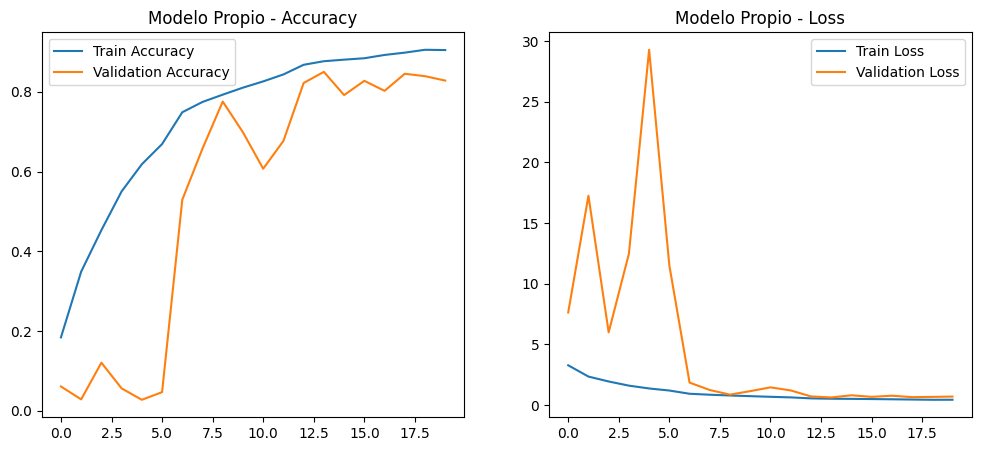

In [ ]:
# Obtener grafica de resultados
plot_training_history(history_prop, 'Modelo Propio')

In [ ]:
# Evaluación final

val_loss, val_acc = modelo_propio.evaluate(val_gen)
print(f"Accuracy final en validación: {val_acc*100:.2f}%")

78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8570 - loss: 0.6010
Accuracy final en validación: 84.98%


###VGG16 - RESULTADOS

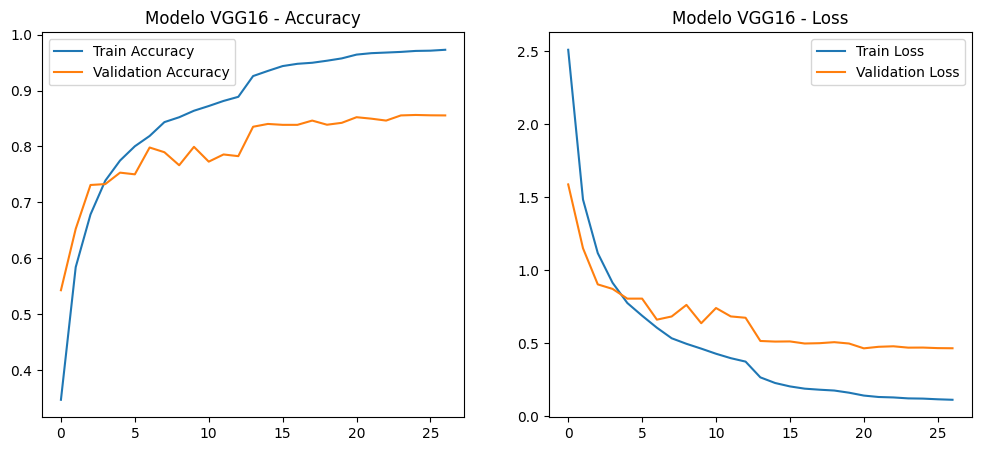

In [ ]:
# Obtener grafica de resultados
plot_training_history(history_vgg16, 'Modelo VGG16')

In [ ]:
# Evaluación final

val_loss, val_acc = modelo_vgg16.evaluate(val_gen)
print(f"Accuracy final en validación: {val_acc*100:.2f}%")

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.8447 - loss: 0.4798
Accuracy final en validación: 85.24%


###SQUEEZENET RESULTADOS

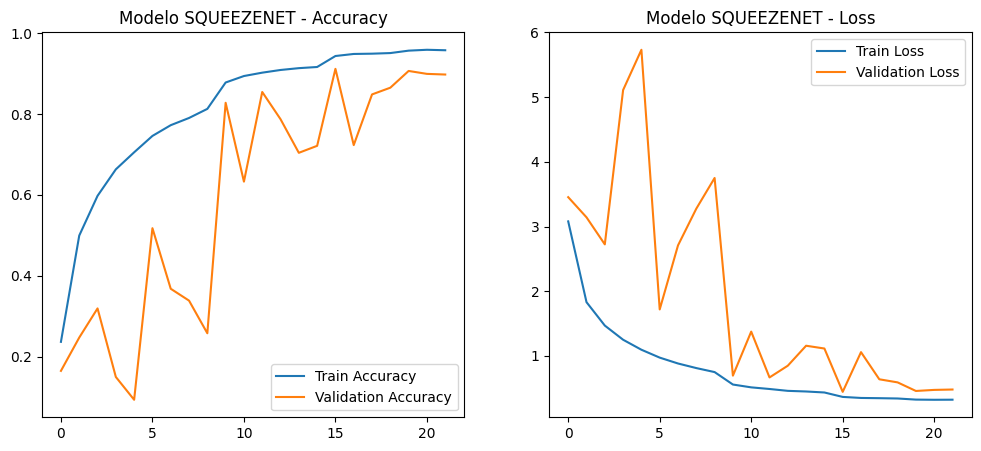

In [ ]:
# Obtener grafica de resultados
plot_training_history(history_vgg16, 'Modelo SQUEEZENET')

In [ ]:
# Evaluación final

val_loss, val_acc = modelo_squeezenet.evaluate(val_gen)
print(f"Accuracy final en validación: {val_acc*100:.2f}%")

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9089 - loss: 0.4584
Accuracy final en validación: 91.16%


###MOBILENETV2 RESULTADOS

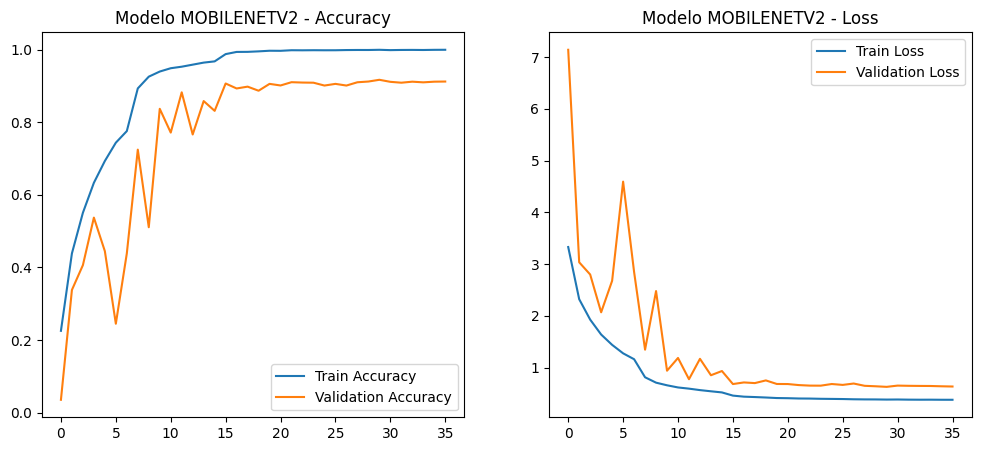

In [ ]:
# Obtener grafica de resultados
plot_training_history(history_mobilenetv2, 'Modelo MOBILENETV2')

In [ ]:
# Evaluación final

val_loss, val_acc = modelo_mobilenet_v2_custom.evaluate(val_gen)
print(f"Accuracy final en validación: {val_acc*100:.2f}%")

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9147 - loss: 0.6206
Accuracy final en validación: 91.67%
